# Topological Assignment Improved (n-most-used-qubits) - v2
This new version takes the improved version of TopologicalAssignment mapper and map the target qubit of a cnot operation on a physical qubit which is close to where the control qubit should be at that point of the algorithm.

**How?**
Let's look at the coupling map of our device:

In [38]:
from copy import copy
from queue import PriorityQueue

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler import Layout, CouplingMap
from qiskit.circuit.library import SwapGate

from qiskit.transpiler import TranspilerError
from qiskit import QuantumCircuit, transpile
from qiskit.test.mock.backends import FakeBrooklyn
import random, os

from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import dag_to_circuit

from tabulate import tabulate

from utils.BasicSwap import BasicSwap
from utils.SwapModified import BasicSwapModified
from utils.TopologicalAssignment import TopologicalAssignment
from utils.TPImproved import TopologicalAssignmentImproved
from utils.cost import *

In [39]:
# info device 65 qubits -- create DAG with 65 qubits
backend = FakeBrooklyn()
num_qubits =  backend.configuration().n_qubits
coupling_list = backend.configuration().coupling_map
coupling_map = CouplingMap(couplinglist=coupling_list)
device_qc = QuantumCircuit(num_qubits, num_qubits)
device_DAG = circuit_to_dag(device_qc)

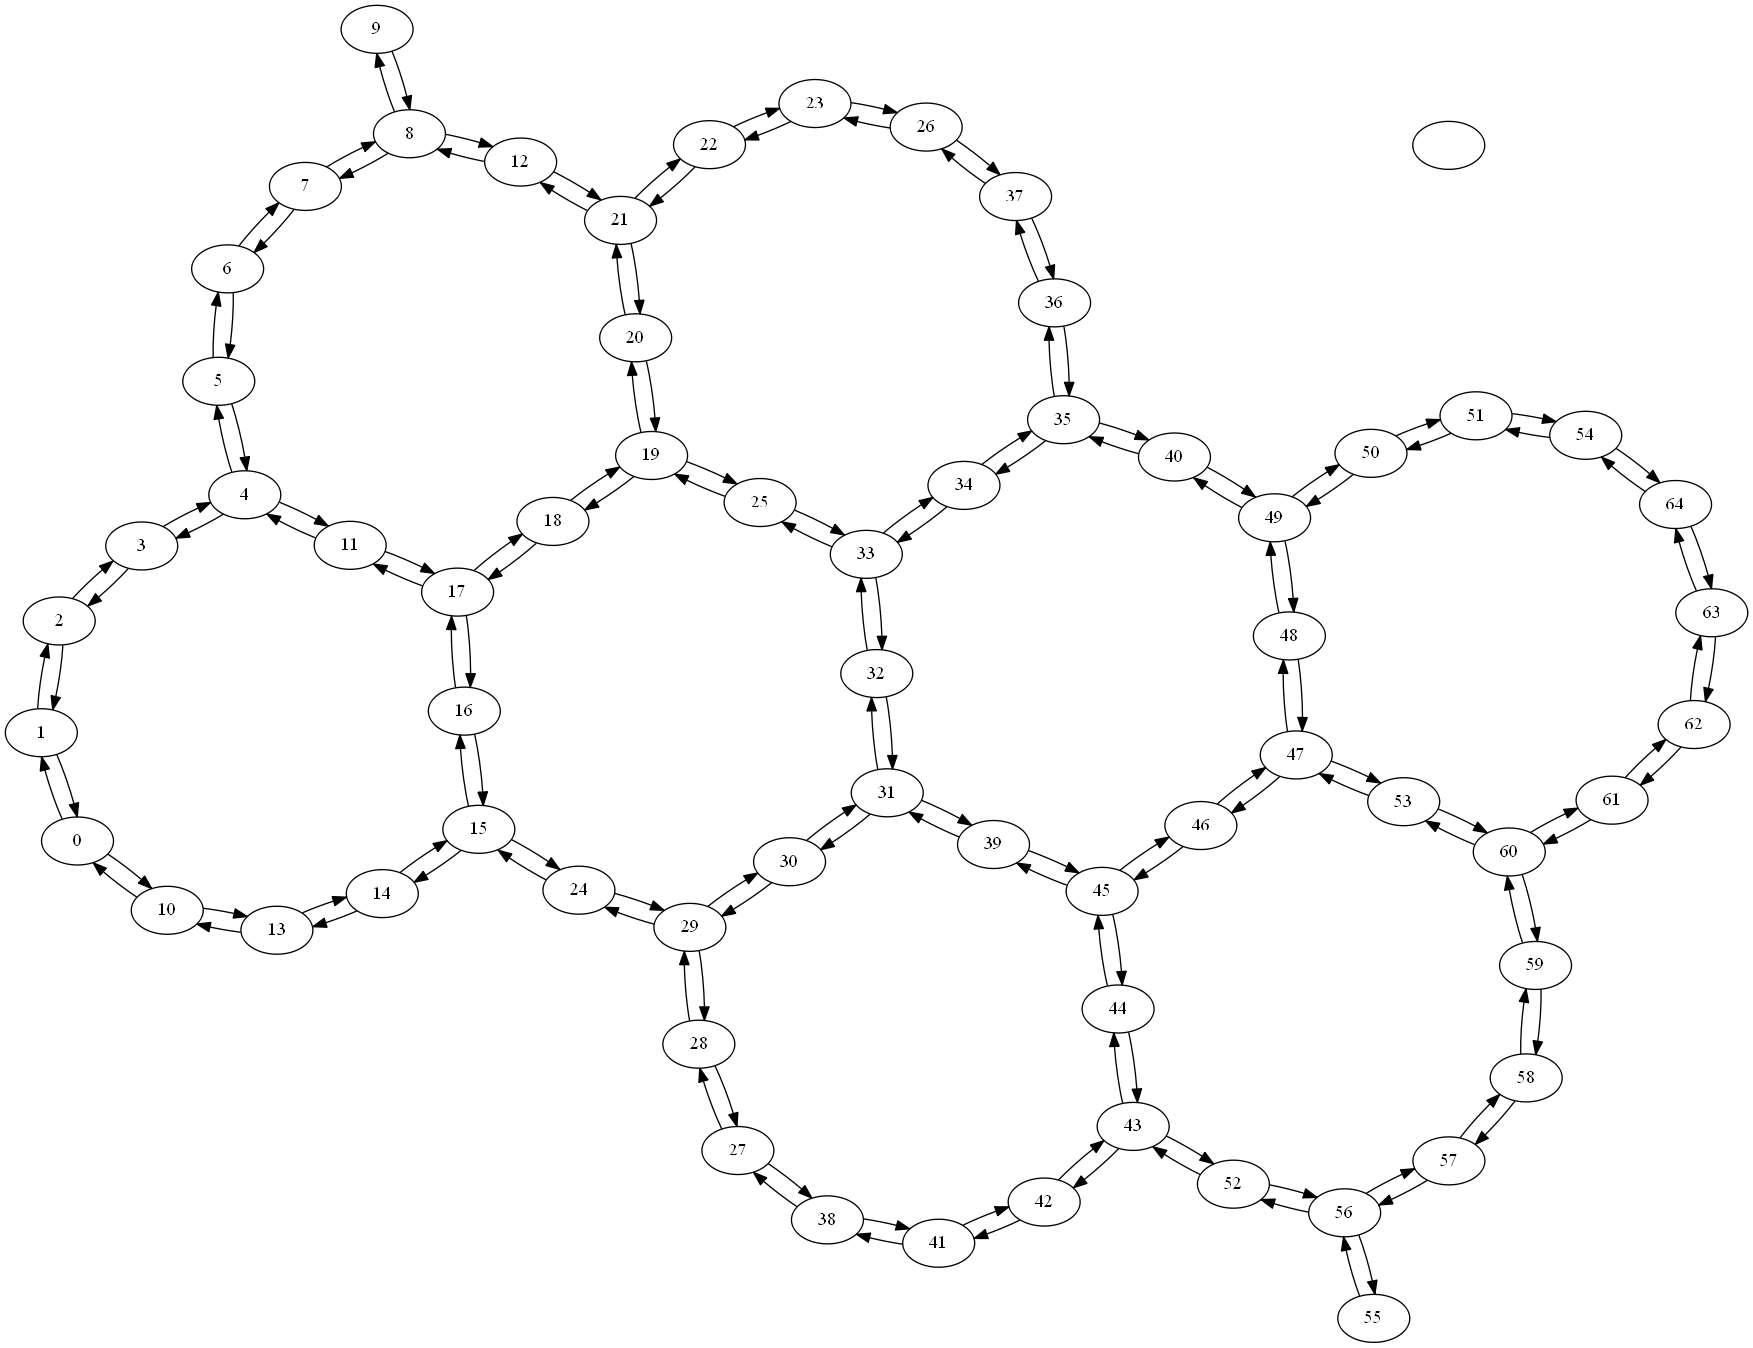

In [37]:
coupling_map.draw()

If we have a circuit composed of n cnot operations where the control qubit is the same, the control qubit would be mapped on physical qubit 31 and all the target qubits would be mapped "around it". 

This is because, for TopologicalAssignment, **we assumed that the control qubit is in the same position** during the algorithm **but** it's not: in fact **swap operations will move it** to get it close to the currrent target qubit.

So, the idea of this version of the mapper is to **map the target qubits of cnot operations close to where the control qubit will be**. How? Remembering the position of the previous target qubit and mapping the current one as close as possible to it.

In [46]:
# Topological Assignment Improved v2

"""
Given the coupling map of a real device and a dag circuit, 
create a layout (map physical qubits to logical) that permits
to have less costs when a basic pass is used

"""

class TopologicalAssignmentImprovedv2():
    
    def __init__(self,
                 coupling_map):
        
        self.coupling_map = coupling_map
        self.num_qubits = 65
    
    
    """
    return an ordered list of the most involved qubits in two-qubits operation
    """
    def most_involved(self, dag):
        q = {}
        for layer in dag.serial_layers():
            subdag = layer['graph']

            for gate in subdag.two_qubit_ops():
                q0 = gate.qargs[0]
                q1 = gate.qargs[1]

                if q0 in q:
                    q[q0] += 1
                else:
                    q[q0] = 1
                if q1 in q:
                    q[q1] += 1
                else:
                    q[q1] = 1

        q_list = sorted(q, key=q.get, reverse=True)
        return q_list

    def run(self, dag,n_most_used):
               
        # create an empty dictionary from a 65 qubit device         
        canonical_register = dag.qregs['q']
        trivial_layout = Layout.generate_trivial_layout(canonical_register)
                
        # initialize layout dictionary
        # keys --> virtual, values --> physical
        # layout_dict[virtual_qbit] to access the physical
        # list(layout_dict.values()) to retrieve the physical qubits used
        layout_dict = trivial_layout.copy().get_virtual_bits() 
        
        # initialize the dictionary such that each virtual qubits is not assigned
        # to any physical qubit
        for virtual in layout_dict.keys():
            layout_dict[virtual] = None
                
        # i: arbitrary starting qubit
        # the ideal is to start mapping the qubits from qubits 
        # which are located in the center of the circuit 
        # (see coupling_map drawing above)
        i = 31
        
        # --- improvement ---
        # use a dictionary to remember the cnot interations between qubits
        interations_dict = {}
        
        # assign the n_most_used logical qubits to the central physical qubits 
        # (usually the most connected)
        most_used_qubits = self.most_involved(dag)
        for n in range(n_most_used):
            layout_dict[most_used_qubits[n]] = i
            i += 1
        
        ###
        assignments = []
        ###
        
        # walk through the dag searching for two-qubits operations
        for layer in dag.serial_layers():
            subdag = layer['graph']
            for gate in subdag.two_qubit_ops():

                physical_q0 = layout_dict[gate.qargs[0]]
                physical_q1 = layout_dict[gate.qargs[1]]
                switched = 0

                ###
                a = False
                b = False
                if physical_q0 == None:
                    a = True
                if physical_q1 == None:
                    b = True
                ###
                # gate defines a two qubits op with virtual qubits gate.qargs[0] and gate.qargs[1]
                if physical_q0 == None: #physical qubit not associated yet
                    if physical_q1 == None:
                        layout_dict[gate.qargs[0]] = i
                        physical_q0 = i
                    else:
                        physical_q0 = layout_dict[gate.qargs[1]] 
                        physical_q1 = layout_dict[gate.qargs[0]]
                        switched = 1  # keep track that now physical_q0 contains virtual_q1
 
                # physical_q0 is now assigned
                if physical_q1 == None: #physical qubit not associated yet
                    assigned = False      
                
                    # --- improvement ---
                    # don't take the minimal distance from physical_q0 but from 
                    # physical_q1 of the previous cnot operation that physical_q0 
                    # was involved into
                    # e.g. cx(0,50) cx(0,2) assigns virtual qubit 2 to physical qubit close to 50
                    # (because physical qubit 0 will be moved anyway by the basicPass, close to 50)
                    if physical_q0 in interations_dict.keys():
                        past_ph0_interaction = interations_dict[physical_q0]
                        #print('past interaction: ', physical_q0, past_ph0_interaction)
                        #print('distance: ', coupling_map.distance(physical_q0, past_ph0_interaction))
                        if coupling_map.distance(physical_q0, past_ph0_interaction) == 1:
                            distance_q0 = self.coupling_map.distance_matrix[physical_q0].copy()
                        else:
                            distance_q0 = self.coupling_map.distance_matrix[past_ph0_interaction].copy()
                    else:
                        distance_q0 = self.coupling_map.distance_matrix[physical_q0].copy()
                    physical_assigned = [x for x in layout_dict.values() if x is not None]
                    
                    # starting from qubits with distance 1, take all the qubits that 
                    # have that distance from physical_q0 (candidates): if one of them is not assigned yet,
                    # assign it, otherwise increase the distance allowed
                    for j in range(1, int(distance_q0.max()) + 1):  #let j as close as possible to physical_q0
                        candidates = [index for index, element in enumerate(distance_q0) if element == j] #element is the distance from q0
                        random.shuffle(candidates)
                        
                        for n in candidates: #search in the nearest qubits wrt q0
                            if n not in physical_assigned:
                                layout_dict[gate.qargs[1 - switched]] = n
                                physical_q1 = n
                                assigned = True
                                break
                        if assigned == True:
                            break
                            
                    # physical_q1 should be assigned
                    if assigned == False:
                        raise TranspilerError('The layout does not match the amount of qubits in the DAG')                    
                
                interations_dict[layout_dict[gate.qargs[0]]] = layout_dict[gate.qargs[1]]
                #print('int-dict-------\n',physical_q1,interations_dict)
                
                physical_assigned =  [x for x in layout_dict.values() if x is not None] 
                if len(physical_assigned) == self.num_qubits: # the mapping is completed
                    break
                    
                while i in physical_assigned:  #let i as close as possible to the previous qubits
                    i += 1
                    if i == 65:
                        i = 0
                        
                ###
                if a is True:
                    assignments.append(physical_q0 if not switched else physical_q1)
                    a = False
                if b is True:
                    assignments.append(physical_q1 if not switched else physical_q0)
                    b = False
                ###
                
        #print('\n-->This is how physical qubits have been assigned by the algorithm (in order):\n', assignments)
                
        physical = [x for x in layout_dict.values() if x is not None]
        #print('\n\nNum of physical unique qubit assigned (without unused qubits): --',len(physical), ' out of ', len(layout_dict.keys()))

        # map all the unused qubits
        used = [x for x in layout_dict.values() if x is not None]
        total = list(range(0, self.num_qubits))
        unused = [x for x in total if x not in used]  
        
        for virtual in layout_dict.keys():
            if layout_dict[virtual] == None:
                layout_dict[virtual] = unused[0]
                unused.pop(0)
        
        #check        
        physical = set(layout_dict.values())
        #print('\nNum of physical unique qubit assigned (with used qubits): --',len(physical), ' out of ', len(layout_dict.keys()))
        
        layout = Layout(layout_dict)
        return layout

In [42]:
# info input circuit n <= 65 qubits -- create DAG with n qubits
file_name = 'adder-3'
input_path = './original/' + file_name + '.qasm'
qc = QuantumCircuit.from_qasm_file(path=input_path)
input_DAG = circuit_to_dag(qc) 

# build the input_DAG (n qubits) on the device_DAG (65 qubits)
# now device_DAG has 65 qubits with the structure of the input_DAG
device_DAG.compose(input_DAG)

In [47]:
# create and run the mapper: a mapping (layout) is returned
tp = TopologicalAssignmentImprovedv2(coupling_map)
tp_layout = tp.run(device_DAG, 1)
print('\n--------------Mapping-------------\n---Physical qubit : Virtual qubit---\n', tp_layout)


--------------Mapping-------------
---Physical qubit : Virtual qubit---
 Layout({
45: Qubit(QuantumRegister(65, 'q'), 0),
46: Qubit(QuantumRegister(65, 'q'), 1),
32: Qubit(QuantumRegister(65, 'q'), 2),
39: Qubit(QuantumRegister(65, 'q'), 3),
30: Qubit(QuantumRegister(65, 'q'), 4),
31: Qubit(QuantumRegister(65, 'q'), 5),
0: Qubit(QuantumRegister(65, 'q'), 6),
1: Qubit(QuantumRegister(65, 'q'), 7),
2: Qubit(QuantumRegister(65, 'q'), 8),
3: Qubit(QuantumRegister(65, 'q'), 9),
4: Qubit(QuantumRegister(65, 'q'), 10),
5: Qubit(QuantumRegister(65, 'q'), 11),
6: Qubit(QuantumRegister(65, 'q'), 12),
7: Qubit(QuantumRegister(65, 'q'), 13),
8: Qubit(QuantumRegister(65, 'q'), 14),
9: Qubit(QuantumRegister(65, 'q'), 15),
10: Qubit(QuantumRegister(65, 'q'), 16),
11: Qubit(QuantumRegister(65, 'q'), 17),
12: Qubit(QuantumRegister(65, 'q'), 18),
13: Qubit(QuantumRegister(65, 'q'), 19),
14: Qubit(QuantumRegister(65, 'q'), 20),
15: Qubit(QuantumRegister(65, 'q'), 21),
16: Qubit(QuantumRegister(65, 'q'),

## --- do not consider this --- 
I want to see graphically how 3 different topological mappers perform on a single input

In [48]:
input_DAG.draw(filename='./output/tpi/devicedag.jpg')

In [7]:
device_DAG.draw(filename='./output/tpi/devicedag1.jpg')

### 1

In [8]:
# tp assignment
qc2 = qc.copy()
new_input_DAG2 = circuit_to_dag(qc2) 

# build the input_DAG on the device_DAG (65 qubits)
new_device_qc2 = QuantumCircuit(num_qubits, num_qubits)
new_device_DAG2 = circuit_to_dag(new_device_qc2) 
new_device_DAG2.compose(new_input_DAG2)

tp = TopologicalAssignment(coupling_map)
tp_layout = tp.run(new_device_DAG2)
basic_pass_modified = BasicSwapModified(coupling_map, tp_layout)
new_dag_tp_assignment = basic_pass_modified.run(new_device_DAG2)
cost_tp_assignment = compute_cost(new_dag_tp_assignment)
print(cost_tp_assignment)
new_dag_tp_assignment.draw(filename='./output/tpi/devicedag2.jpg')

gates---
 {'rz': 34, 'rx': 0, 'sx': 6, 'cx': 24, 'swap': 11, 'barrier': 1, 'measure': 6}


Cost of the circuit: 576
576


### 2

In [9]:
# tp improved - most used
qc_copy = qc.copy()
new_input_DAG = circuit_to_dag(qc_copy) 

# build the input_DAG on the device_DAG (65 qubits)
new_device_qc = QuantumCircuit(num_qubits, num_qubits)
new_device_DAG = circuit_to_dag(new_device_qc) 
new_device_DAG.compose(new_input_DAG)

tpi = TopologicalAssignmentImproved(coupling_map)
tp_layouti = tpi.run(new_device_DAG, 2) # n is from 0 to (n_most_used - 1)
basic_pass_modifiedi = BasicSwapModified(coupling_map, tp_layouti)
new_dag_tp_assignmnet_i = basic_pass_modifiedi.run(new_device_DAG)
cost_tp_assignment_i = compute_cost(new_dag_tp_assignmnet_i)
print(cost_tp_assignment_i)
new_dag_tp_assignmnet_i.draw(filename='./output/tpi/devicedag3.jpg')

gates---
 {'rz': 34, 'rx': 0, 'sx': 6, 'cx': 24, 'swap': 11, 'barrier': 1, 'measure': 6}


Cost of the circuit: 576
576


### 3

In [49]:
# tp improved v2 
qc_copy = qc.copy()
new_input_DAG = circuit_to_dag(qc_copy) 

# build the input_DAG on the device_DAG (65 qubits)
new_device_qc = QuantumCircuit(num_qubits, num_qubits)
new_device_DAG = circuit_to_dag(new_device_qc) 
new_device_DAG.compose(new_input_DAG)

tpi = TopologicalAssignmentImprovedv2(coupling_map)
tp_layouti = tpi.run(new_device_DAG, 2) # n is from 0 to (n_most_used - 1)
basic_pass_modifiedi = BasicSwapModified(coupling_map, tp_layouti)
new_dag_tp_assignmnet_i = basic_pass_modifiedi.run(new_device_DAG)
cost_tp_assignment_i = compute_cost(new_dag_tp_assignmnet_i)
print(cost_tp_assignment_i)
new_dag_tp_assignmnet_i.draw(filename='./output/tpi/devicedag4.jpg')

gates---
 {'rz': 34, 'rx': 0, 'sx': 6, 'cx': 24, 'swap': 10, 'barrier': 1, 'measure': 6}


Cost of the circuit: 546
546


### ---continue from here ---

# Now you have the layout 
so you can use it as input of the Basic pass. n.b. You must use the modified version of the basic pass that doesn't build another trivial layout but uses the layout given as parameter.

Define costs functions for all the mappers

In [55]:
# return a list of costs with the following mappers: 
# basic_swap, lv3, topological_assignment, topological_assignment_improved
def compute_costs(qc):
    # create a circuit the same size as the device, in terms of qubits and clbits
    qc1 = qc.copy()
    device_qc_1 = QuantumCircuit(num_qubits, num_qubits)
    device_DAG_1 = circuit_to_dag(device_qc_1) 
    initial_layout_1 = Layout.generate_trivial_layout(*device_DAG_1.qregs.values())
    
    input_DAG_1 = circuit_to_dag(qc1) 
    

    # build the input_DAG on the device_DAG (65 qubits)
    device_DAG_1.compose(input_DAG_1)
    
    # for basic pass
    basic_pass = BasicSwap(coupling_map, initial_layout_1)
    new_dag_basic_pass = basic_pass.run(device_DAG_1)
    cost_basic_pass = compute_cost(new_dag_basic_pass)
    print('basic pass - ok \n')
    
    # for traspiler lv3
    new_circ_lv3 = transpile(qc1, backend=backend, optimization_level=3)
    new_dag_lv3 = circuit_to_dag(new_circ_lv3)
    cost3 = compute_cost(new_dag_lv3)
    print('transpiler pass lv3 - ok \n')
    
    # for topological assignment
    qc2 = qc.copy()
    new_input_DAG2 = circuit_to_dag(qc2) 
    
    # build the input_DAG on the device_DAG (65 qubits)
    new_device_qc2 = QuantumCircuit(num_qubits, num_qubits)
    new_device_DAG2 = circuit_to_dag(new_device_qc2) 
    new_device_DAG2.compose(new_input_DAG2)
    
    tp = TopologicalAssignment(coupling_map)
    tp_layout = tp.run(new_device_DAG2)
    basic_pass_modified = BasicSwapModified(coupling_map, tp_layout)
    new_dag_tp_assignment = basic_pass_modified.run(new_device_DAG2)
    cost_tp_assignment = compute_cost(new_dag_tp_assignment)
    print('tp assignment - ok \n')
    
    return [cost_basic_pass, cost3, cost_tp_assignment]

In [53]:
def compute_cost_tp_improved(qc, n_most_used):
    # for topological assignment improved - take n most used qubit
    total_cost = []
    for n in range(n_most_used):
        qc_copy = qc.copy()
        new_input_DAG = circuit_to_dag(qc_copy) 

        # build the input_DAG on the device_DAG (65 qubits)
        new_device_qc = QuantumCircuit(num_qubits, num_qubits)
        new_device_DAG = circuit_to_dag(new_device_qc) 
        new_device_DAG.compose(new_input_DAG)

        tpi = TopologicalAssignmentImproved(coupling_map)
        tp_layouti = tpi.run(new_device_DAG, n + 1) # n is from 0 to (n_most_used - 1)
        basic_pass_modifiedi = BasicSwapModified(coupling_map, tp_layouti)
        new_dag_tp_assignmnet_i = basic_pass_modifiedi.run(new_device_DAG)
        cost_tp_assignment_i = compute_cost(new_dag_tp_assignmnet_i)
        total_cost.append(cost_tp_assignment_i)
        print('tp assignment improved - ',n + 1, ' most used qubit - ok \n')

    return total_cost

**Run** the mappers with different inputs

In [56]:
folderpath = r".\original" # make sure to put the 'r' in front
filepaths  = [os.path.join(folderpath, name) for name in os.listdir(folderpath)]
table_rows = []

# for this project we just analyse up to 5 most used qubits
n_most_used = 5

for i in range(5):
#for i in range(len(filepaths)):
    print('------------iteration ', i, '-----------  file: ', filepaths[i], '----------')
    input_path3 = filepaths[i]
    qc3 = QuantumCircuit.from_qasm_file(path=input_path3)
    costs = compute_costs(qc3)
    costs += compute_cost_tp_improved(qc3, n_most_used)
    print('tot------', costs)
    row = [input_path3.rsplit('\\', 1)[1]]
    row.extend(costs)
    table_rows.append(row)  

------------iteration  0 -----------  file:  .\original\adder-13.qasm ----------
gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 874, 'barrier': 1, 'measure': 26}


Cost of the circuit: 31186
basic pass - ok 

gates---
 {'rz': 995, 'rx': 0, 'sx': 405, 'cx': 1291, 'swap': 0, 'x': 26, 'barrier': 1, 'measure': 26}


Cost of the circuit: 13315
transpiler pass lv3 - ok 

gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 697, 'barrier': 1, 'measure': 26}


Cost of the circuit: 25876
tp assignment - ok 

gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 667, 'barrier': 1, 'measure': 26}


Cost of the circuit: 24976
tp assignment improved -  1  most used qubit - ok 

gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 715, 'barrier': 1, 'measure': 26}


Cost of the circuit: 26416
tp assignment improved -  2  most used qubit - ok 

gates---
 {'rz': 534, 'rx': 0, 'sx': 26, 'cx': 494, 'swap': 676, 'barrier': 1, 'measure': 26}


Cost of the circuit: 25246
tp

In [57]:
table = [['benchmark name', 'basic swap', 'lv=3', 'tp assignment', 'tpi_1', 'tpi_2', 'tpi_3', 'tpi_4', 'tpi_5']]
table.extend(table_rows)

print('--------------------------- Cost in terms of gates-------------------------------------------------------')
print(tabulate(table,headers='firstrow', tablefmt='fancy_grid', numalign='center'))

--------------------------- Cost in terms of gates-------------------------------------------------------
╒═══════════════════╤══════════════╤════════╤═════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│ benchmark name    │  basic swap  │  lv=3  │  tp assignment  │  tpi_1  │  tpi_2  │  tpi_3  │  tpi_4  │  tpi_5  │
╞═══════════════════╪══════════════╪════════╪═════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ adder-13.qasm     │    31186     │ 13315  │      25876      │  24976  │  26416  │  25246  │  28126  │  29866  │
├───────────────────┼──────────────┼────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ adder-16.qasm     │    48202     │ 20030  │      47182      │  45352  │  47782  │  47782  │  47482  │  48952  │
├───────────────────┼──────────────┼────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ adder-3.qasm      │     786      │  490   │       576       │   576   │   576   │   486   │   

# Let's compare different solution
Using different mappers on several inputs we can see that, overall, the **TopologicalAssignmentImproved v2 that maps firstly the-most-used-qubit** (tpi_1) performs equal or better than TopologicalAssignment without any improvements, moving closer to the optimized transpiler lv3 from the Qiskit library: *see the red dots*.

We can also notice that **mapping at the beginning just the first-most-used-qubit** it is often the best choice, but somehow mapping at the beginning more than one most used qubit leads to an improvement in terms of cost reduction: *see green dots*.

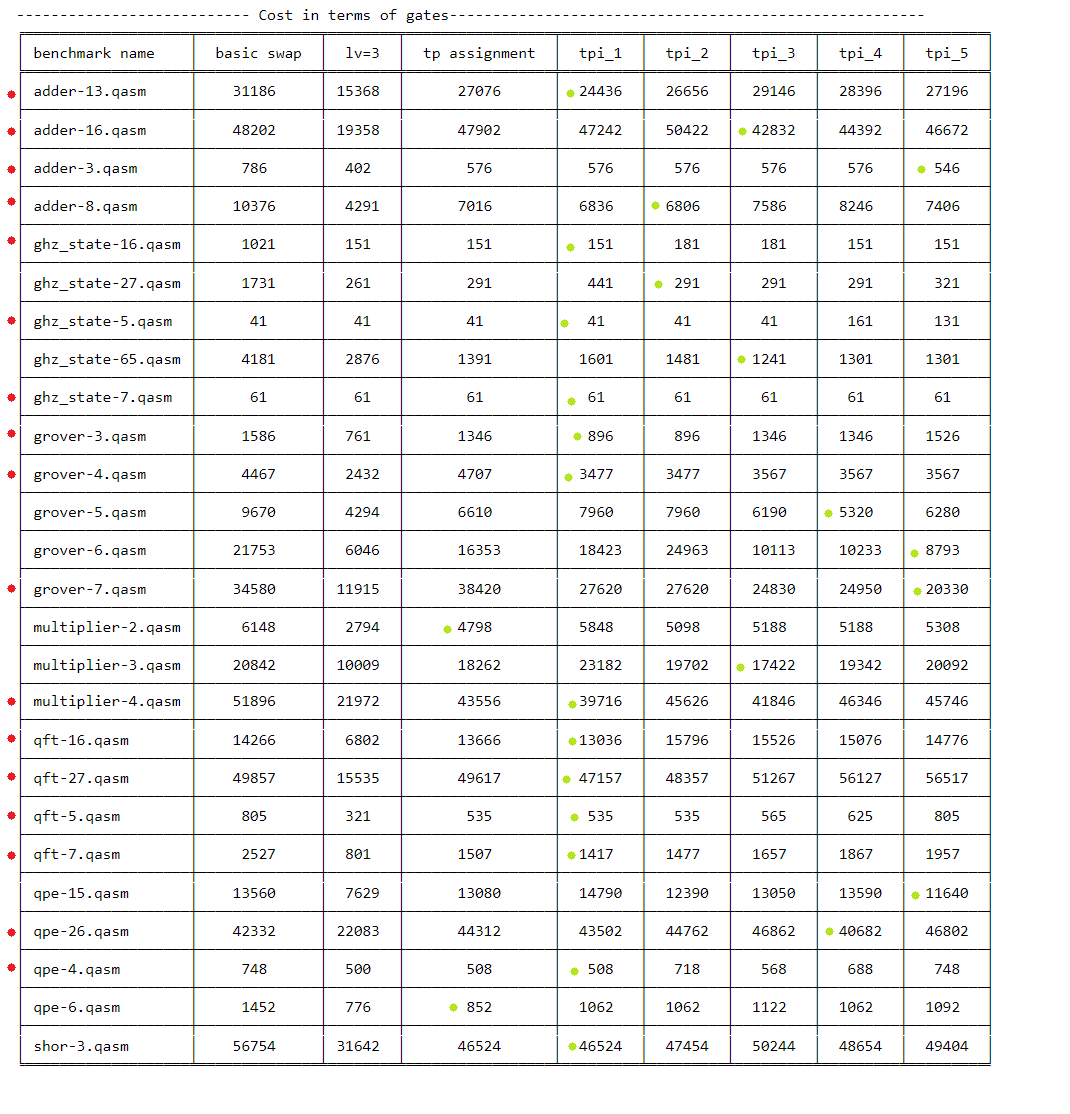

In [33]:
from IPython.display import Image
Image(filename='./output/tpi/comparison.png')

# Conclusions

It's quite easy to find how to reduce the cost of a circuit (it has been shown that either fixing some qubits at the beginning of the procedure or try to follow the movements of the control qubit lead to (even small but necessary) improvements in terms of cost reduction. 

The next step would be: **what does lead a circuit to be mapped better with one solution or another?**